In [1]:
import krpc
import numpy as np
import time
import math

In [2]:
linkup = krpc.connect('192.168.1.2', name='flight control')

In [3]:
ksc = linkup.space_center
vessel = ksc.active_vessel

In [4]:
def cross_product(x, y):
    return (x[1]*y[2] - x[2]*y[1], x[2]*y[0] - x[0]*y[2], x[0]*y[1] - x[1]*y[0])

def dot_product(x, y):
    return x[0]*y[0] + x[1]*y[1] + x[2]*y[2]

def magnitude(x):
    return math.sqrt(x[0]**2 + x[1]**2 + x[2]**2)

def vector_proection(vec, norm):
    return dot_product(vec,norm)  / magnitude(norm)

def vector_projection_on_plane(vec, plane_norm):
    pass

def angle_between_vectors(x, y):
    """ Compute the angle between vector x and y """
    dp = dot_product(x, y)
    if dp == 0:
        return 0
    xm = magnitude(x)
    ym = magnitude(y)
    return math.acos(dp / (xm*ym)) * (180. / math.pi)

def angle_between_vector_and_plane(x, n):
    """ Compute the angle between a vector x and plane with normal vector n """
    dp = dot_product(x,n)
    if dp == 0:
        return 0
    xm = magnitude(x)
    nm = magnitude(n)
    return math.asin(dp / (xm*nm)) * (180. / math.pi)

In [ ]:
def vertical_launch_orientation_initial(ksc, vessel):
    '''Orientation for vertical launch of roundish vehicles. Initial launch.
        good while the vessel pointed mostly straight up
        
        pitch: angle between forward and horizon due-starboard
        roll: angle between starboard and east
    '''
    up = (1,0,0)
    east = (0,0,1)
    
    forward = ksc.transform_direction((0,1,0), vessel.reference_frame, vessel.surface_reference_frame)
    starboard = ksc.transform_direction((1,0,0), vessel.reference_frame, vessel.surface_reference_frame)
    
    B = A - (A.dot.N)N
    
    
    
    starboard_horizon = tuple(s-u for s,u in zip(starboard,up))
    
    pitch = angle_between_vectors(forward, starboard_horizon)
    roll = angle_between_vectors(starboard, east)
    
    return pitch, roll

def vertical_launch_orientation_low(ksc, vessel):
    '''Orientation for vertical launch of roundish vehicles. Low-altitude.
        good once vessel has a definite heading
        good until vessel is pointed about 45 deg above horizon
        
        pitch: angle between forward and up
        roll: angle between starboard and east
        heading: 
    '''
    east = (0,0,1)
    
    flight = vessel.flight(vessel.surface_reference_frame)
    starboard = ksc.transform_direction((1,0,0), vessel.reference_frame, vessel.surface_reference_frame)
    roll = angle_between_vectors(starboard, east)
    
    return flight.pitch, flight.heading, roll

def vertical_launch_orientation_high(ksc, vessel):
    '''Orientation for vertical launch of roundish vehicles. High-altitude to orbit.
        good once vessel is pointed to within 45 deg of the horizon
        
        pitch: angle between forward and up
        roll: angle between starboard and east
    '''
    flight = vessel.flight(vessel.surface_reference_frame)
    return flight.pitch, flight.heading, flight.roll
    

In [5]:
def vessel_surface_orientation(ksc, vessel):
    vessel_direction = vessel.direction(vessel.surface_reference_frame)
    
    # Get the direction of the vessel in the horizon plane
    horizon_direction = (0, vessel_direction[1], vessel_direction[2])
    
    # Compute the pitch - the angle between the vessels direction
    # and the direction in the horizon plane
    pitch = angle_between_vectors(vessel_direction, horizon_direction)
    if vessel_direction[0] < 0:
        pitch = -pitch

    # Compute the heading - the angle between north
    # and the direction in the horizon plane
    north = (0,1,0)
    heading = angle_between_vectors(north, horizon_direction)
    if horizon_direction[2] < 0:
        heading = 360 - heading

    # Compute the roll
    # Compute the plane running through the vessels direction
    # and the upwards direction
    up = (1,0,0)
    plane_normal = cross_product(vessel_direction, up)
    # Compute the upwards direction of the vessel
    vessel_up = ksc.transform_direction(
        (0,0,-1), vessel.reference_frame, vessel.surface_reference_frame)
    # Compute the angle between the upwards direction of the vessel and the plane
    roll = angle_between_vector_and_plane(vessel_up, plane_normal)
    # Adjust so that the angle is between -180 and 180 and
    # rolling right is +ve and left is -ve
    if vessel_up[0] > 0:
        roll *= -1
    elif roll < 0:
        roll += 180
    else:
        roll -= 180
        
    return pitch, heading, roll

In [6]:
print(vessel_surface_orientation(ksc,vessel))

(89.95713173684966, 270.3354599848029, -91.05429884046353)


In [7]:
import wernher

In [8]:
con = wernher.Controller()

In [9]:
con.kp = .1
con.ki = 0.05
con.kd = .2
con.cmin = -1
con.cmax = 1

In [10]:
tt,roll,conroll = [],[],[]
con.t0 = ksc.ut
con.set_point = vessel_surface_orientation(ksc,vessel)[2]*3.14159/180
while True:
    t = ksc.ut
    p,h,r = vessel_surface_orientation(ksc,vessel)
    c = con(r*3.14159/180,t)
    tt.append(t)
    roll.append(r)
    conroll.append(c)
    vessel.control.roll = c
    time.sleep(1/100)

KeyboardInterrupt: 

In [13]:
tt = np.array(tt)
roll = np.array(roll)
conroll = np.array(conroll)

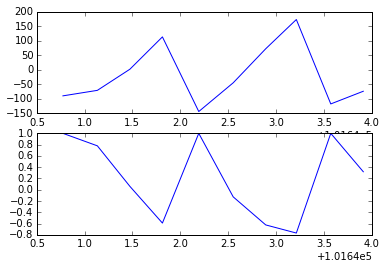

In [24]:
%matplotlib inline
from matplotlib import pyplot
fig,ax = pyplot.subplots(2)
ax[0].plot(tt[:10],roll[:10])
ax[1].plot(tt[:10],conroll[:10])

In [21]:
print(tt)

[ 101640.77278381  101641.13278381  101641.47278381  101641.81278381
  101642.19278381  101642.55278381  101642.89278381  101643.21278381
  101643.57278381  101643.91278381  101644.29278381  101644.61278381
  101644.95278381  101645.27278381  101645.61278381  101646.01278381
  101646.37278381  101646.69278381  101647.03278381  101647.37278381
  101647.79278381  101648.11278381  101648.45278381  101648.81278381
  101649.13278381  101649.45278381  101649.79278381  101650.15278381
  101650.51278381  101650.85278381  101651.17278381  101651.51278381
  101651.85278381  101652.19278381  101652.51278381  101652.85278381
  101653.17278381  101653.53278381  101653.87278381  101654.21278381
  101654.53278381  101654.87278381  101655.15278381  101655.47278381
  101655.83278381  101656.17278381  101656.49278381  101656.83278381
  101657.17278381  101657.49278381  101657.85278381  101658.25278381
  101658.57278381  101658.95278381  101659.31278381  101659.69278381
  101660.01278381  101660.39278381

In [22]:
print(roll)

[ -90.65857882  -71.68403997    1.22500603  112.74839453 -144.73931832
  -45.64570829   71.7869815   172.65753901 -118.51359402  -74.75169824
   13.78494628  112.37484976  174.44541738 -158.1828721  -113.31885381
  -22.21232791   59.90721861  112.43109347  139.87828353  147.03122558
  143.36377255  135.97850052  124.471226    109.52586338   88.02747022
   67.42182814   42.23027153   17.42897081   -4.94207915  -22.96774447
  -39.80190554  -56.72733216  -71.25735099  -86.08183228  -97.82160259
 -107.60644586 -117.1767522  -123.64956273 -127.5135368  -129.69536249
 -131.29961396 -131.85754835 -131.62160558 -130.25038756 -128.33797474
 -125.85314476 -122.42778926 -118.56364137 -114.96097685 -111.17327884
 -106.95030713 -102.99592547  -99.4223812   -95.9767651   -93.13610249
  -90.19695801  -87.7997902   -85.93754992  -84.28298917  -82.86812272
  -82.02957338  -81.58756088  -81.32194471  -81.18011646  -81.3540939
  -81.7583353   -82.30252782  -82.95334208  -83.80197978  -84.55983321
  -85.3

In [23]:
print(conroll)

[  1.00000000e+00   7.78296357e-01   5.94308685e-02  -5.91809929e-01
   1.00000000e+00  -1.27010506e-01  -6.24772664e-01  -7.68860328e-01
   1.00000000e+00   3.18422226e-01  -2.34524156e-01  -7.25265711e-01
  -4.73869357e-01   1.00000000e+00   2.30986034e-01  -2.86138355e-01
  -4.77757750e-01  -4.02651697e-01  -2.27606386e-01  -1.02065519e-01
  -7.72796782e-02  -7.74147665e-02  -8.33854175e-02  -9.32104796e-02
  -1.58066537e-02  -3.35418799e-02   5.05215984e-03  -3.56371562e-03
  -1.48049685e-02  -3.50858581e-02  -2.11535221e-02  -1.13501915e-02
  -1.61443722e-02   1.15898023e-02   1.01271478e-02   4.82532421e-03
   3.30561751e-02   1.32909936e-02   8.07329449e-03   6.38913496e-03
   1.58217461e-02   1.74433527e-02   1.85321047e-02   1.53626539e-02
   2.04834797e-02   1.98168925e-02   1.10401032e-02   1.04639030e-02
   1.42666912e-02   9.23850353e-03   7.56341168e-03   1.16367433e-02
   3.55813293e-03   6.85645229e-03   6.99118886e-03   2.47175863e-03
  -1.47672905e-03   2.96849583e-03